# Corona and Flu Spread 2019-2020

The aim of this notebook is to track the spread of Corona virus and, for comparison, seasonal flu.

- Comparison flu vs corona: https://www.npr.org/sections/goatsandsoda/2020/03/20/815408287/how-the-novel-coronavirus-and-the-flu-are-alike-and-different?t=1584960018733
- World flu deaths: https://www.npr.org/sections/goatsandsoda/2020/03/20/815408287/how-the-novel-coronavirus-and-the-flu-are-alike-and-different?t=1584960018733

Todo:

- Find flu database. National statistics on death causes. Deaths on flu and pneumonia are often grouped together.
  - Sweden: https://sdb.socialstyrelsen.se/if_dor/val.aspx
  - Denmark: https://www.dst.dk/da/Statistik/emner/befolkning-og-valg/doedsfald-og-middellevetid/doedsfald
  - USA: https://www.kff.org/other/state-indicator/influenza-and-pneumonia-death-rate/?currentTimeframe=0&sortModel=%7B"colId":"Location","sort":"asc"%7D

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.misc import derivative
import datetime

In [89]:
today = datetime.date.today().strftime("%Y-%m-%d")
# source: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
url = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-29.xlsx"
#file = "COVID-19-geographic-disbtribution-worldwide-2020-03-22.xlsx"
db = pd.read_excel(url, usecols=[0,4,5,6], converters= {'DateRep': pd.to_datetime})
db.rename(columns={"countriesAndTerritories": "Country"}, inplace=True, errors="raise")
db.rename(columns={"dateRep": "Date"}, inplace=True, errors="raise")
db.rename(columns={"deaths": "Dead"}, inplace=True, errors="raise")
db.rename(columns={"cases": "Cases"}, inplace=True, errors="raise")
db.sort_values('Date', inplace=True)
db["Deadsum"] = db.groupby(by=['Country']).cumsum().Dead

# read and mangle country population database
population = pd.read_html("https://en.wikipedia.org/wiki/List_of_countries_by_population_(United_Nations)")[1]
population.drop(columns=[1,2,3,5], inplace=True)
population = population.rename(columns={0: "Country", 4: "Population"}).dropna()
population["Country"] = population["Country"].replace(to_replace="China[a]", value="China")
population["Country"] = population["Country"].replace(to_replace="Spain[d]", value="Spain")
population["Country"] = population["Country"].replace(to_replace="Norway[m]", value="Norway")
population["Country"] = population["Country"].replace(to_replace="France[b]", value="France")
population["Country"] = population["Country"].replace(to_replace="Czech Republic", value="Czech_Republic")
population["Country"] = population["Country"].replace(to_replace="United Kingdom", value="United_Kingdom")
population["Country"] = population["Country"].replace(to_replace="United States", value="United_States_of_America")

# merge the two databases above
db = pd.merge(db, population, on="Country")
db.Population = db["Population"].astype(int).values
db["dead_per_million"] = db.Deadsum / db.Population * 1e6
db

,Date,Cases,Dead,Country,Deadsum,Population,dead_per_million
0,2019-12-31,0,0,Israel,0,8519377,0.0
1,2020-01-01,0,0,Israel,0,8519377,0.0
2,2020-01-02,0,0,Israel,0,8519377,0.0
3,2020-01-03,0,0,Israel,0,8519377,0.0
4,2020-01-04,0,0,Israel,0,8519377,0.0
...,...,...,...,...,...,...,...
5734,2020-03-28,0,0,Mali,0,19658031,0.0
5735,2020-03-29,5,0,Mali,0,19658031,0.0
5736,2020-03-27,2,0,Anguilla,0,14869,0.0
5737,2020-03-28,0,0,Anguilla,0,14869,0.0


In [90]:
# total deaths by flu or pneumonia in 2018. Sources from links above
flu = dict(
    Denmark=2103, # Source: DST
    Sweden=2578,  # Source: SDB
    USA=59120,    # Source: see above
    Italy=24981   # Source: https://www.ijidonline.com/article/S1201-9712(19)30328-5/fulltext (Note 2016/2017)
)
flu = pd.DataFrame.from_dict(flu, columns=[ "Country"], orient='index').reset_index().rename(columns={"index": "Country", "Country": "total_deaths"})
flu = pd.merge(flu, population, on='Country')
flu.Population = flu["Population"].astype(int).values
flu['dead_per_million'] = flu.total_deaths / flu.Population * 1e6
flu

,Country,total_deaths,Population,dead_per_million
0,Denmark,2103,5771876,364.352942
1,Sweden,2578,10036379,256.865549
2,Italy,24981,60550075,412.567614


# Time evolution

The plot below shows accumulated deaths due to COVID 19, while for seasonal flu and pnemonia it's the cumulated sum for the whole year (high-resolution data not found so far). The right-hand graphs shows the data on a logarithmic scale to better see the rate.

Some statistics:

- according to www.dst.dk, 53958 people died in Denmark in 2019. Of these, 41672 were 70 years of age or older, corresponding to 77% of recorded deaths.
- as of March 23, 13 people have died in Denmark of COVID 19, predominantly in the 70+ age group mentioned above. This corresponds to 0.03% of the deaths in that group. Obviously this number will increase over the year.

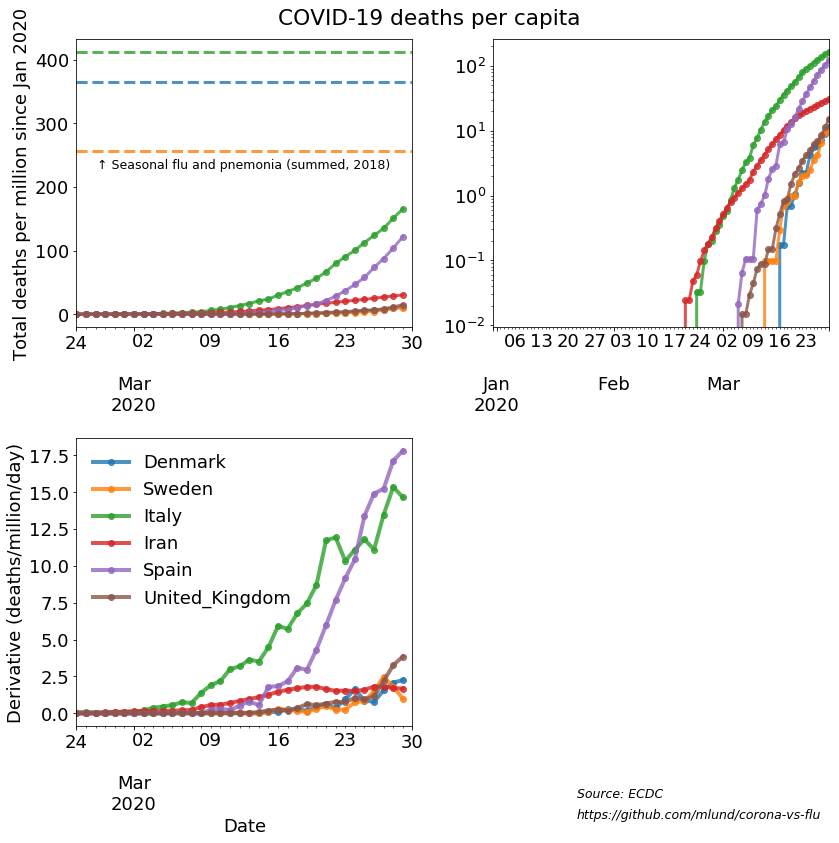

In [92]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [12, 12]})
fig, ax = plt.subplots(2, 2, sharex=False)

countries = ['Denmark', 'Sweden', 'Italy', 'Iran', 'Spain', 'United_Kingdom']
for country in countries:
    ykey="dead_per_million"
    mask = db["Country"] == country

    slope = np.gradient(db[mask][ykey].values)
    pd.Series(slope, db[mask].Date).plot(ax=ax[1][0], lw=4, alpha=0.8, label=country, ls='-', marker='o')

    db[mask].plot(x="Date", y=ykey, ax=ax[0][0], lw=3, alpha=0.8, marker='o')
    db[mask].plot(x="Date", y=ykey, ax=ax[0][1], lw=3, alpha=0.8, marker='o')

ax[0][0].set_ylabel("Total deaths per million since Jan 2020")
ax[0][0].set_xlabel("")
ax[0][1].set_xlabel("")
ax[0][1].set_yscale('log')
#ax[1][0].set_yscale('log')
ax[0][0].set_yscale('linear')
ax[1][0].set_ylabel('Derivative (deaths/million/day)')
ax[1][0].legend(loc=0, frameon=False)
ax[0][0].get_legend().remove()
ax[0][1].get_legend().remove()
fig.delaxes(ax[1][1])

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
cnt=0
for country in ['Denmark', 'Sweden', 'Italy']:
    mask = flu.Country == country
    val = flu[mask].dead_per_million.values
    ax[0][0].axhline(y=val, color=colors[cnt], linestyle='--', lw=3, alpha=0.8)
    cnt+=1

ax[0][0].set_xlim('2020-02-24', today)
ax[1][0].set_xlim('2020-02-24', today)

ax[0][0].text(0.06, 0.55, r'↑ Seasonal flu and pnemonia (summed, 2018)', transform=ax[0][0].transAxes, size='x-small')
ax[0][0].text(0.60, 1.05, 'COVID-19 deaths per capita', size='large', transform=ax[0][0].transAxes)

ax[0][1].text(0.25, -1.63, 'Source: ECDC', transform=ax[0][1].transAxes, size='x-small', style='italic')
ax[0][1].text(0.25, -1.7, 'https://github.com/mlund/corona-vs-flu', transform=ax[0][1].transAxes, size='x-small', style='italic')
    
plt.tight_layout()
#plt.savefig('corona-vs-flu.png', bbox_inches='tight')


In [93]:
l = db.Country.values
[i for i in l if i.startswith('United')]

['United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_States_of_America',
 'United_State